In [1]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

#### The most cointegrated pair based on the data of DECEMBER 2021 is ('PKI', 'S') ( check pairs selection notebook)

In [2]:
## the most cointegrated pair
stock1 = pd.read_csv('data/2021-december/PKI.csv')
stock2 = pd.read_csv('data/2021-december/S.csv')
beta = 3.8312600785683832

In [3]:
spread = stock1.Close - beta * stock2.Close

### Checking for stationarity over spreads

In [4]:
import matplotlib.pyplot as plt

The mean of the spread is : 0.21564519689464448


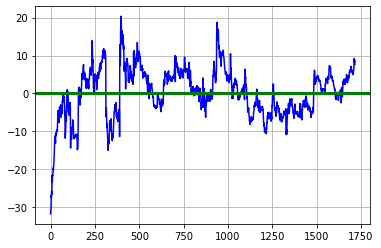

In [5]:
print("The mean of the spread is :",spread.mean())
plt.plot(spread,'b')
plt.axhline(y=spread.mean(), color='g', linestyle='-',linewidth=3)
plt.grid()
plt.show()

#### ADFULLER TEST

In [6]:

from statsmodels.tsa.stattools import adfuller
result = adfuller(spread)

In [7]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.503918
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import deque
import random
import pandas as pd
import numpy as np
import torch.optim as optim

In [9]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 
dev

'cpu'

In [10]:
torch.cuda.is_available()

False

In [11]:
!pwd

/home/myihbach/Desktop/Pairs_Trading/Pairs_trading_git/Code


In [12]:
import os

In [13]:
os.environ['CUDA_VISIBLE_DEVICES']

KeyError: 'CUDA_VISIBLE_DEVICES'

In [10]:
torch.zeros(1).cuda()

RuntimeError: No CUDA GPUs are available

In [14]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining network to optimize our Q function
        self.model = nn.Sequential(
          nn.Linear(10,50),
          nn.ReLU(),
          nn.Linear(50,50),
          nn.ReLU(),
          nn.Linear(50,3)
        )
        

    ## Train model
    def train(self,X,Y):
        criterion = nn.HuberLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        running_loss = 0.0
        for i in range(len(X)):
            inputs, labels= torch.FloatTensor(X[i]), torch.FloatTensor(Y[i])
            optimizer.zero_grad()
            out = self.model(inputs)
            loss = criterion(out, labels)
            loss.backward()          ## This does back propagation
            optimizer.step()         ## To optimize loss function 
            running_loss+=loss.item()  ## the value of the loss function after training
        
        return running_loss
    
    

In [21]:
class Agent:
    def __init__(self, state_size,window_size,trend, skip,batch_size,stock1,stock2):
        self.stock1 = stock1
        self.stock2 = stock2
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3 
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.model = DQN()
        
    def act(self,state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return torch.argmax(self.model.model(torch.FloatTensor(state)))
    
    def get_state(self,t):
        current_mean = sum(self.trend[:t])/len(self.trend[:t+1])
        
        
        daily_returns = self.trend[t] - self.trend[t-1] if t >= 1 else 0.0
        spread_mean_15 = sum(self.trend[t-15:t]) / 15 if t>=15 else sum(self.trend[:t+1]) /(t+1)
        mean_over_15 = current_mean / spread_mean_15
        spread_mean_10 = sum(self.trend[t-10:t]) / 10 if t>=10 else sum(self.trend[:t+1]) /(t+1)
        mean_over_10 = current_mean/spread_mean_10
        spread_mean_7 = sum(self.trend[t-7:t]) / 7 if t>=7 else sum(self.trend[:t+1]) /(t+1)
        mean_over_7 = current_mean/spread_mean_7
        spread_mean_5 = sum(self.trend[t-5:t]) / 5 if t>=5 else sum(self.trend[:t+1]) /(t+1)
        mean_over_5 = current_mean/spread_mean_5
        
        state = [self.trend[t],daily_returns,
                 spread_mean_15,mean_over_15,
                 spread_mean_10,mean_over_10,
                 spread_mean_7,mean_over_7,
                 spread_mean_5,mean_over_5]
        
        return np.array([state])
    
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory1 = [self.stock1[0]]
        inventory2=[]
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t] and len(inventory2)>0 and t < (len(self.trend) - self.half_window):
                bought_price = inventory2.pop(0)
                inventory1.append(self.stock1[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 sell 2 at difference %f, total balance %f'% (t, self.trend[t], initial_money))
                
            elif action == 2 and starting_money >= -self.trend[t] and len(inventory1)>0 and t < (len(self.trend) - self.half_window):
                bought_price = inventory1.pop(0)
                inventory2.append(self.stock2[t])
                initial_money += self.trend[t]
                states_sell.append(t)
                print('day %d: buy 2 sell 1 at difference %f, total balance %f'% (t, self.trend[t], initial_money))
                
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def replay(self,batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l-batch_size,l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model.model(torch.FloatTensor(states)).tolist()
        Q_new = self.model.model(torch.FloatTensor(new_states)).tolist()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            
            if not done:
                target[action] += self.gamma * max(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train(X,Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def train(self, iterations, checkpoint, initial_money,):
        for i in range(iterations):
            total_profit = 0
            inventory1 = [self.stock1[0]]
            inventory2 = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and len(inventory2)>0:
                    bought_price = inventory2.pop(0)
                    inventory1.append(self.stock1[t])
                    starting_money -= self.trend[t] 
                    
                elif action == 2 and starting_money >= -self.trend[t] and len(inventory1)>0:
                    bought_price = inventory1.pop(0)
                    inventory2.append(self.stock2[t])
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)

                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)   
            total_profit = starting_money-initial_money
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))               
                

In [22]:
beta

3.8312600785683832

In [23]:
## Action 1: Buy first Sell second
## Action 2: Buy second Sell first
## Difference is first-second

In [24]:
close = spread.values.tolist()[:700]
print(len(close))

700


In [25]:
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
stock1 = pd.read_csv('data/2021-december/PKI.csv').Close.tolist()
stock2 = pd.read_csv('data/2021-december/S.csv').Close.tolist()
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
             stock1 = stock1[:700],
             stock2 = stock2[:700])

In [ ]:
agent.train(iterations = 200, checkpoint = 5, initial_money = initial_money)

In [31]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 18: buy 2 sell 1 at difference -18.790098, total balance 9981.209902
day 134: buy 1 sell 2 at difference -11.201633, total balance 9992.411535
day 142: buy 2 sell 1 at difference -11.071930, total balance 9981.339605
day 409: buy 1 sell 2 at difference 15.455042, total balance 9965.884563
day 562: buy 2 sell 1 at difference 0.767263, total balance 9966.651826


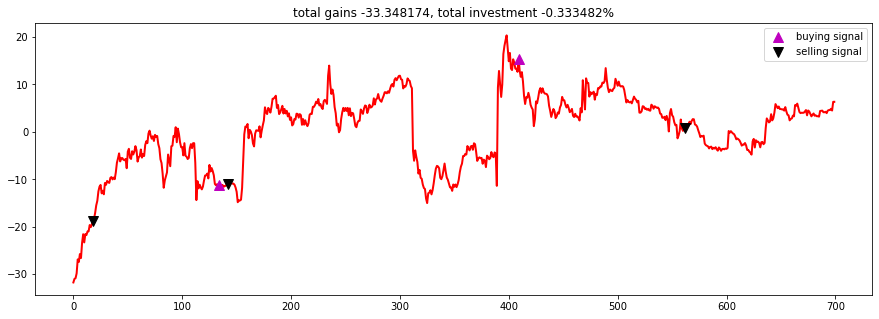

In [32]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend(), '^'
plt.show()

In [132]:
len(states_buy)

4

In [131]:
len(states_sell)

4

In [134]:
len(states_buy[4-3:4])

3